## How Many Reads Do You Need?

In [1]:
%load_ext rpy2.ipython

In [106]:
from random import random
from math import log


pis = [1, 10, 100, 1000, 10 * 1000, 100 * 1000]
ns = [pi * 100 for pi in pis] + [pi * 25 for pi in pis] + [pi * 50 for pi in pis] + [pi * 75 for pi in pis]
pis = [pi / (1000 * 1000) for pi in pis]
NTRIALS = 10
tbl = []
for pi in pis:
    for n in ns:
        for _ in range(NTRIALS):
            observed = sum([1 if random() < pi else 0 for _ in range(n)])
            observed /= n
            ratio = (observed / pi)
            tbl.append([pi, n, int(n * pi + 0.5), ratio])
        


In [125]:
import pandas as pd

tbl = pd.DataFrame(tbl, columns=['prob', 'nreads', 'expected_reads', 'ratio'])


In [130]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl[tbl$expected_reads >= 10,]
mytbl$lr = abs(log2(mytbl$ratio))
ggplot(mytbl, aes(x=expected_reads, y=lr)) +
    geom_point(aes(size=10, color=prob)) + 
    #xlim(0, 100) +
    scale_x_log10() +
    geom_smooth(method='loess') +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    scale_y_sqrt() +
    xlab('Expected Reads') +
    ylab('Abs Log2 (Observed / True)')


Error in tbl[tbl$expected_reads >= 10, ] : incorrect number of dimensions


/home/dcdanko/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in tbl[tbl$expected_reads >= 10, ] : incorrect number of dimensions

  warnings.warn(x, RRuntimeWarning)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Transformation introduced infinite values in continuous y-axis 

  warnings.warn(x, RRuntimeWarning)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Transformation introduced infinite values in continuous y-axis 

  warnings.warn(x, RRuntimeWarning)
/home/dcdanko/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Removed 27 rows containing non-finite values (stat_smooth). 

  warnings.warn(x, RRuntimeWarning)



We can model the chance of detecting a low abundance microbe in our samples based on a given read depth. Let $p_i$ be the proportion of DNA unique to taxa $i$ in our sample. We can then model the number of reads we need to draw $R$ before drawing $n$ reads from taxa $i$ as a negative binomial distribution.

\[ R \sim NB(n, p_i) \]
\[ Pr(R = r) = {r + n - 1 \choose r} p_i^n (1 - p_i)^{r} \]

If we assume we must detect two reads from a given taxa to detect that taxa we can say.

\[ Pr(R = r) = (r + 1) (1 - p_i)^{r} p_i^2 \]

Using the CDF we can state the probability that $R$ is less than a specified number of reads $r$.

\[
    Pr(R \leq r) = \sum_{j=2}^{r}  
        (j + 1) (1 - p_i)^j (p_i)^2
\]

The proportion of DNA which is uniquely assignable to a specific taxa varies by taxa rank and by clade. However, the typical definition specifies that a species have at least 3\% unique DNA. We can use this to state $p_i$ in terms of the abundance of taxa $i$, $t_i$. 

\[ p_i = 0.03 t_i \]

Finally we can summarize the probability of detecting at least two reads that can be uniquely assigned to a taxa with the given relative abundance at several read depths.

In [132]:

def drawn_to_hit(n, p_i, proportion_uniq=0.03):
    hits, total = 0, 0
    while hits < n:
        total += 1
        hits += 1 if random() < (proportion_uniq * p_i) else 0
    return total
        
    
NUM_TO_CALL = [1, 2, 4, 8]
ABS_ABUNDS, TOTAL_READS = [1, 10, 100, 1000], 10 * 1000
REL_ABUNDS = [abund / TOTAL_READS for abund in ABS_ABUNDS]
NTRIALS = 10

tbl = []
for _ in range(NTRIALS):
    for n in NUM_TO_CALL:
        for pi in REL_ABUNDS:
            tbl.append([n, pi, drawn_to_hit(n, pi)])
    

In [145]:
tbl = pd.DataFrame(tbl, columns=['num_hits', 'rel_abund', 'total_reads'])


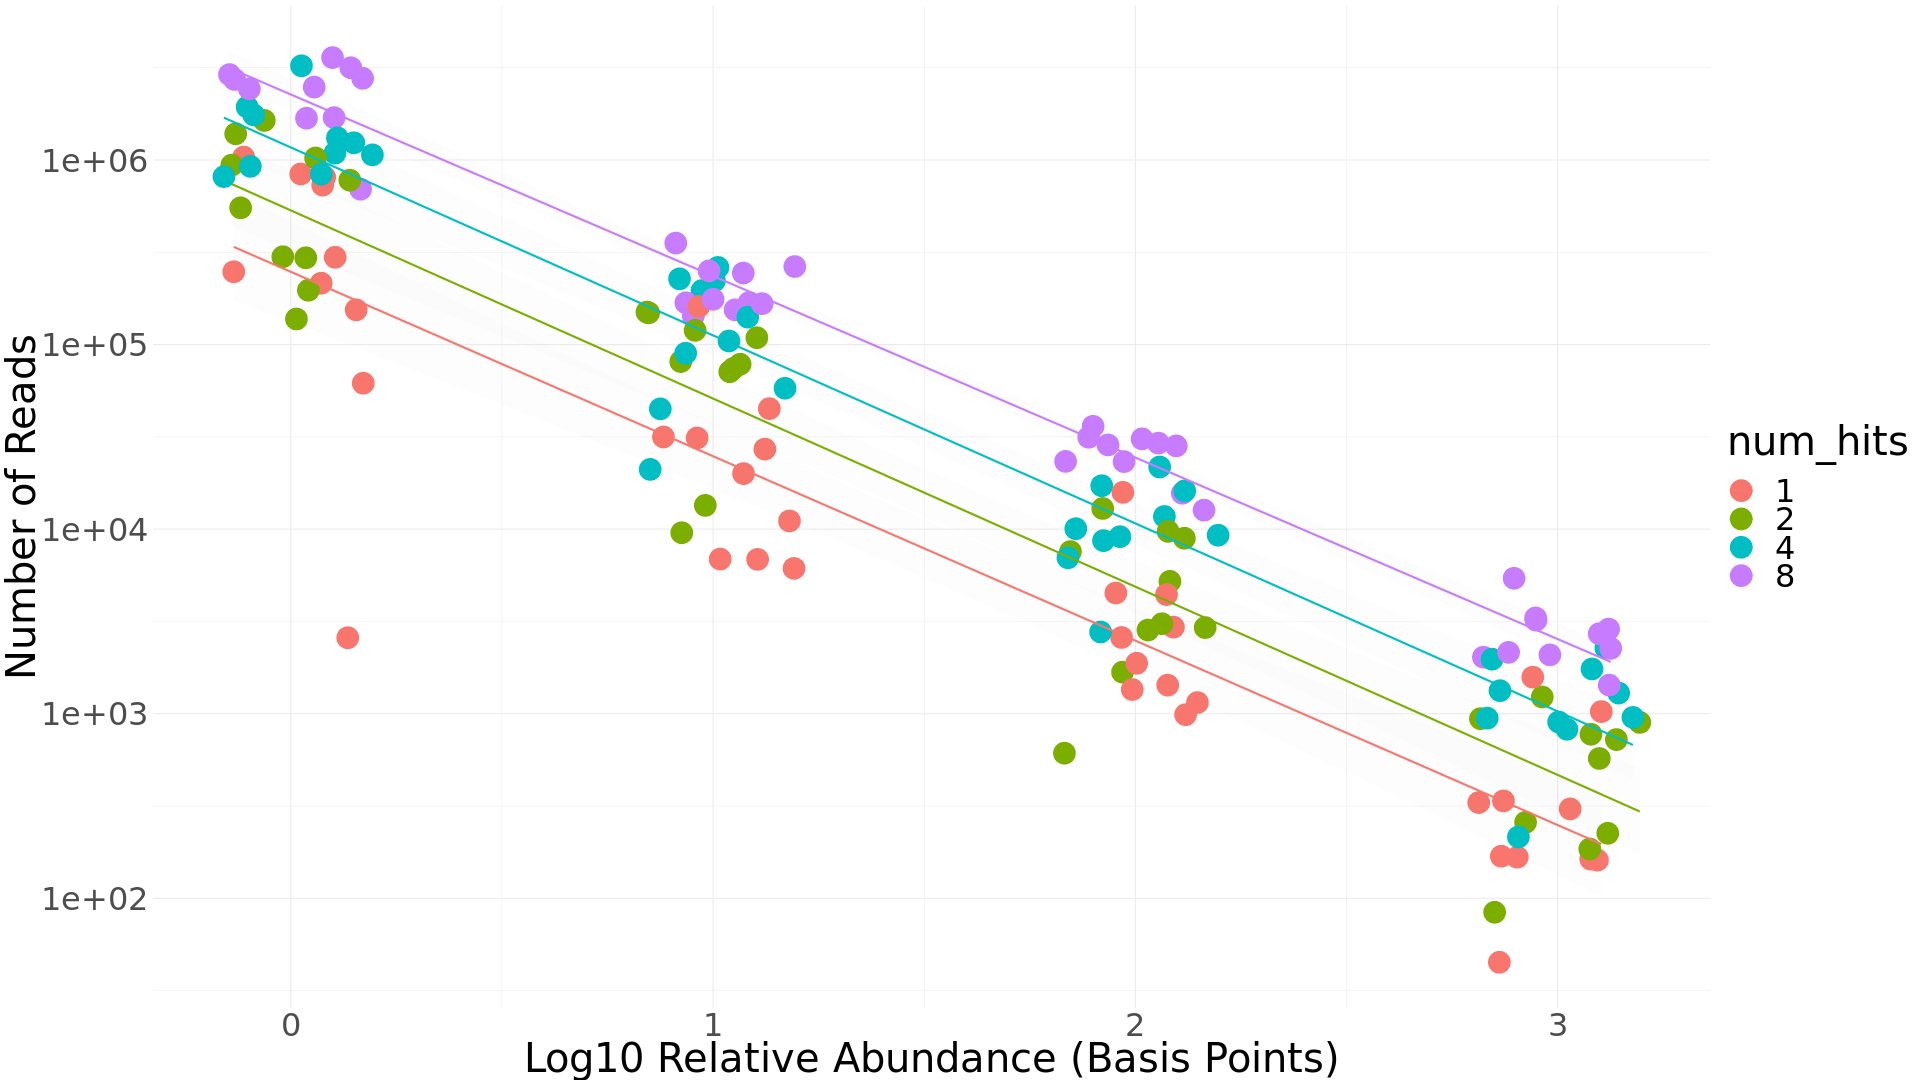

In [147]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl
mytbl$num_hits = as.factor(mytbl$num_hits)
mytbl$basis_pts = jitter(log10(10 * 1000 * mytbl$rel_abund))
ggplot(mytbl, aes(x=basis_pts, y=total_reads, color=num_hits)) +
    geom_point(size=10) + 
    geom_smooth(method='lm', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    scale_y_log10(breaks=c(10, 100, 1000, 10000, 100000, 1000000, 10000000)) +
    xlab('Log10 Relative Abundance (Basis Points)') +
    ylab('Number of Reads')

Takeaway: With a read depth of 5,000,000 reads we will usually detect species at (1 / 10,000). See below and theoretical for caveats

In [211]:

from random import randrange

NUM_TAXA = [10, 100, 1000, 10 * 1000]
READ_DEPTH = [10 * 1000, 100 * 1000, 1000 * 1000, 5 * 1000 * 1000, 10 * 1000 * 1000]
NTRIALS = 3
DETECT=[1,2,4,8]

def sim_seq(read_depth, num_taxa, proportion_uniq=0.03, detect=2):
    taxa = {}
    for _ in range(read_depth):
        if random() < proportion_uniq:
            taxon = randrange(num_taxa)
            taxa[taxon] = 1 + taxa.get(taxon, 0)
    taxa = [val / read_depth for val in taxa.values() if val >= detect]
    num_missing = num_taxa - len(taxa)
    taxa += [0] * num_missing
    taxa_frac = proportion_uniq / num_taxa
    l1 = sum([abs(val - taxa_frac) for val in taxa])
    return num_missing, l1

tbl = []
for _ in range(NTRIALS):
    for read_depth in READ_DEPTH:
        for num_taxa in NUM_TAXA:
            for detect in DETECT:
                num_missing, l1 = sim_seq(read_depth, num_taxa, detect=detect)
                tbl.append([read_depth, num_taxa, detect, num_missing, l1])

In [212]:
tbl = pd.DataFrame(tbl, columns=['read_depth', 'num_taxa', 'detect', 'num_missing', 'l1_dist'])


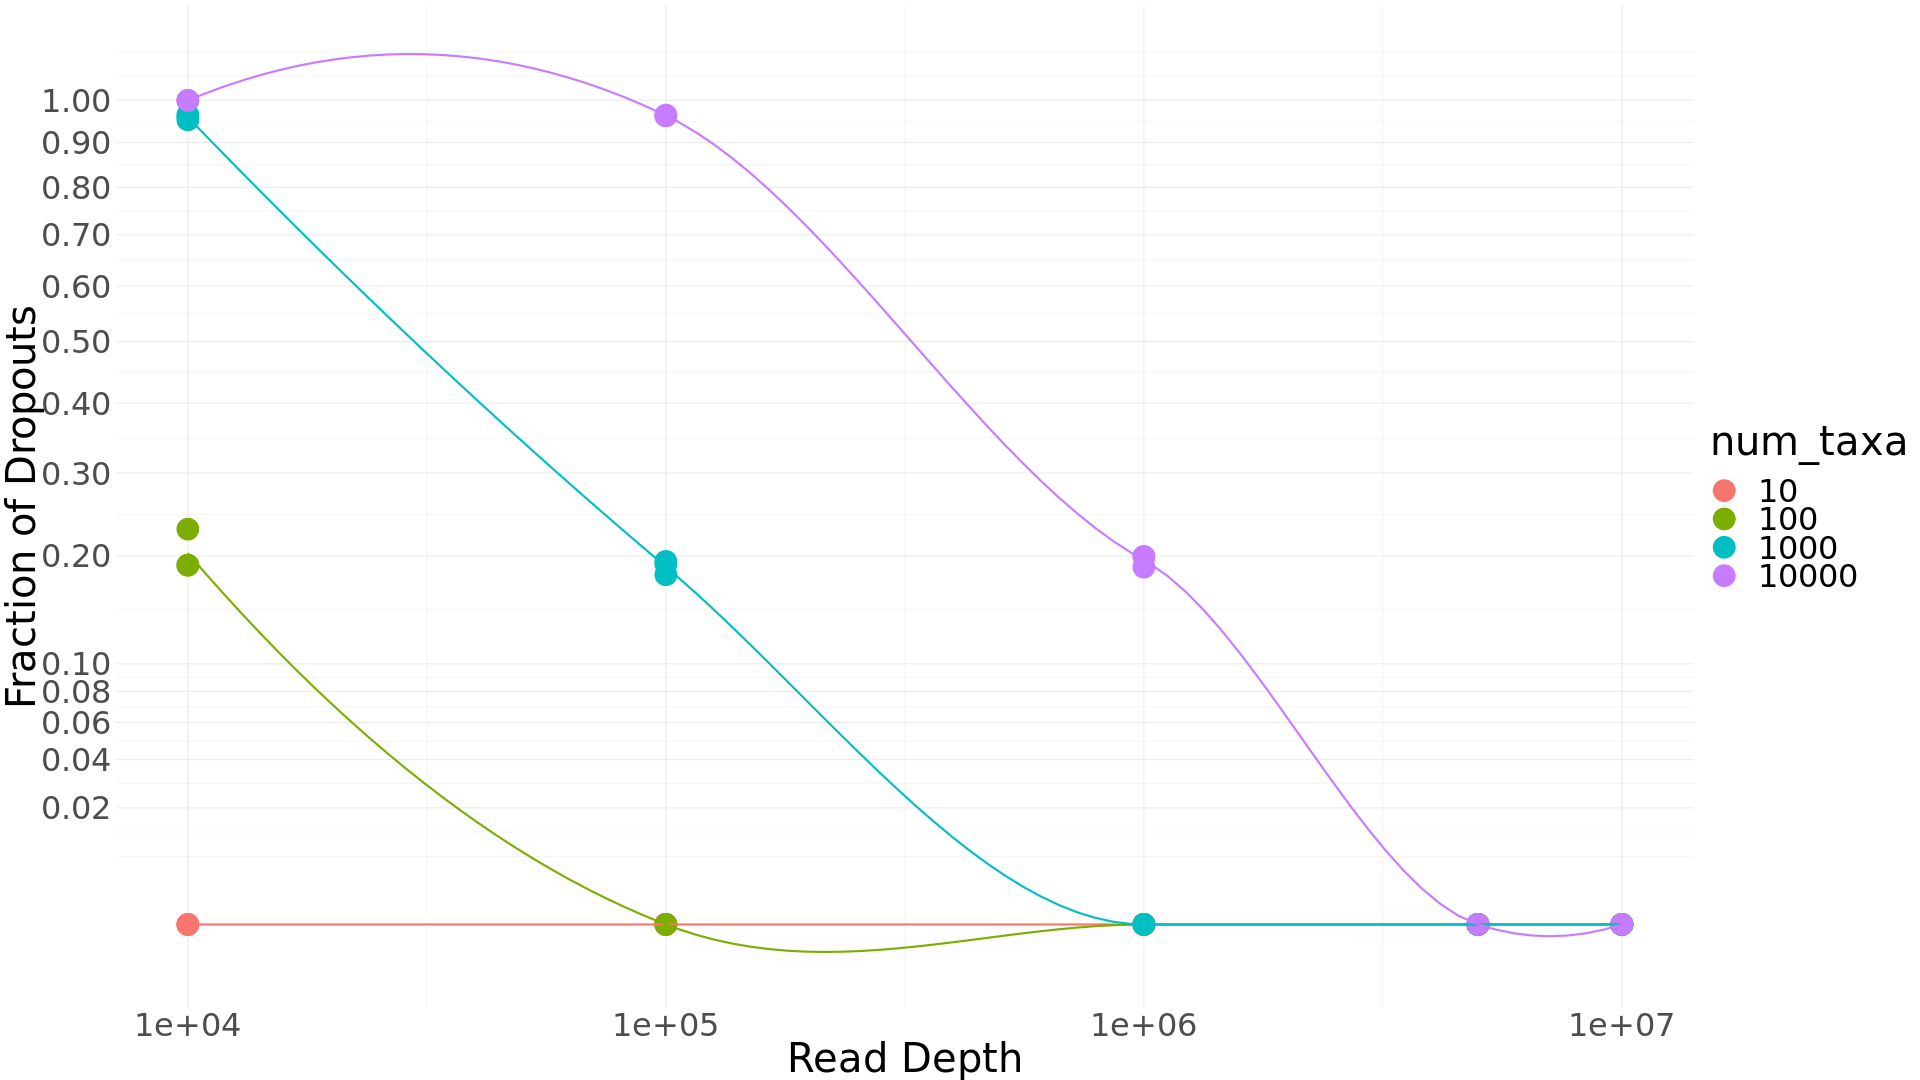

In [215]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl[tbl$detect == 2,]

mytbl$frac_missing = mytbl$num_missing / mytbl$num_taxa
mytbl$num_taxa = as.factor(mytbl$num_taxa)
ggplot(mytbl, aes(x=read_depth, y=frac_missing, color=num_taxa)) +
    geom_point(size=10) + 
    geom_smooth(method='loess', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    #scale_y_log10(breaks=c(10, 100, 1000, 10000)) +
    scale_y_sqrt(breaks=c(1:4/50, 1:10/10)) +
    scale_x_log10(breaks=c(10000,100000,1000000,10000000)) + 
    xlab('Read Depth') +
    ylab('Fraction of Dropouts')

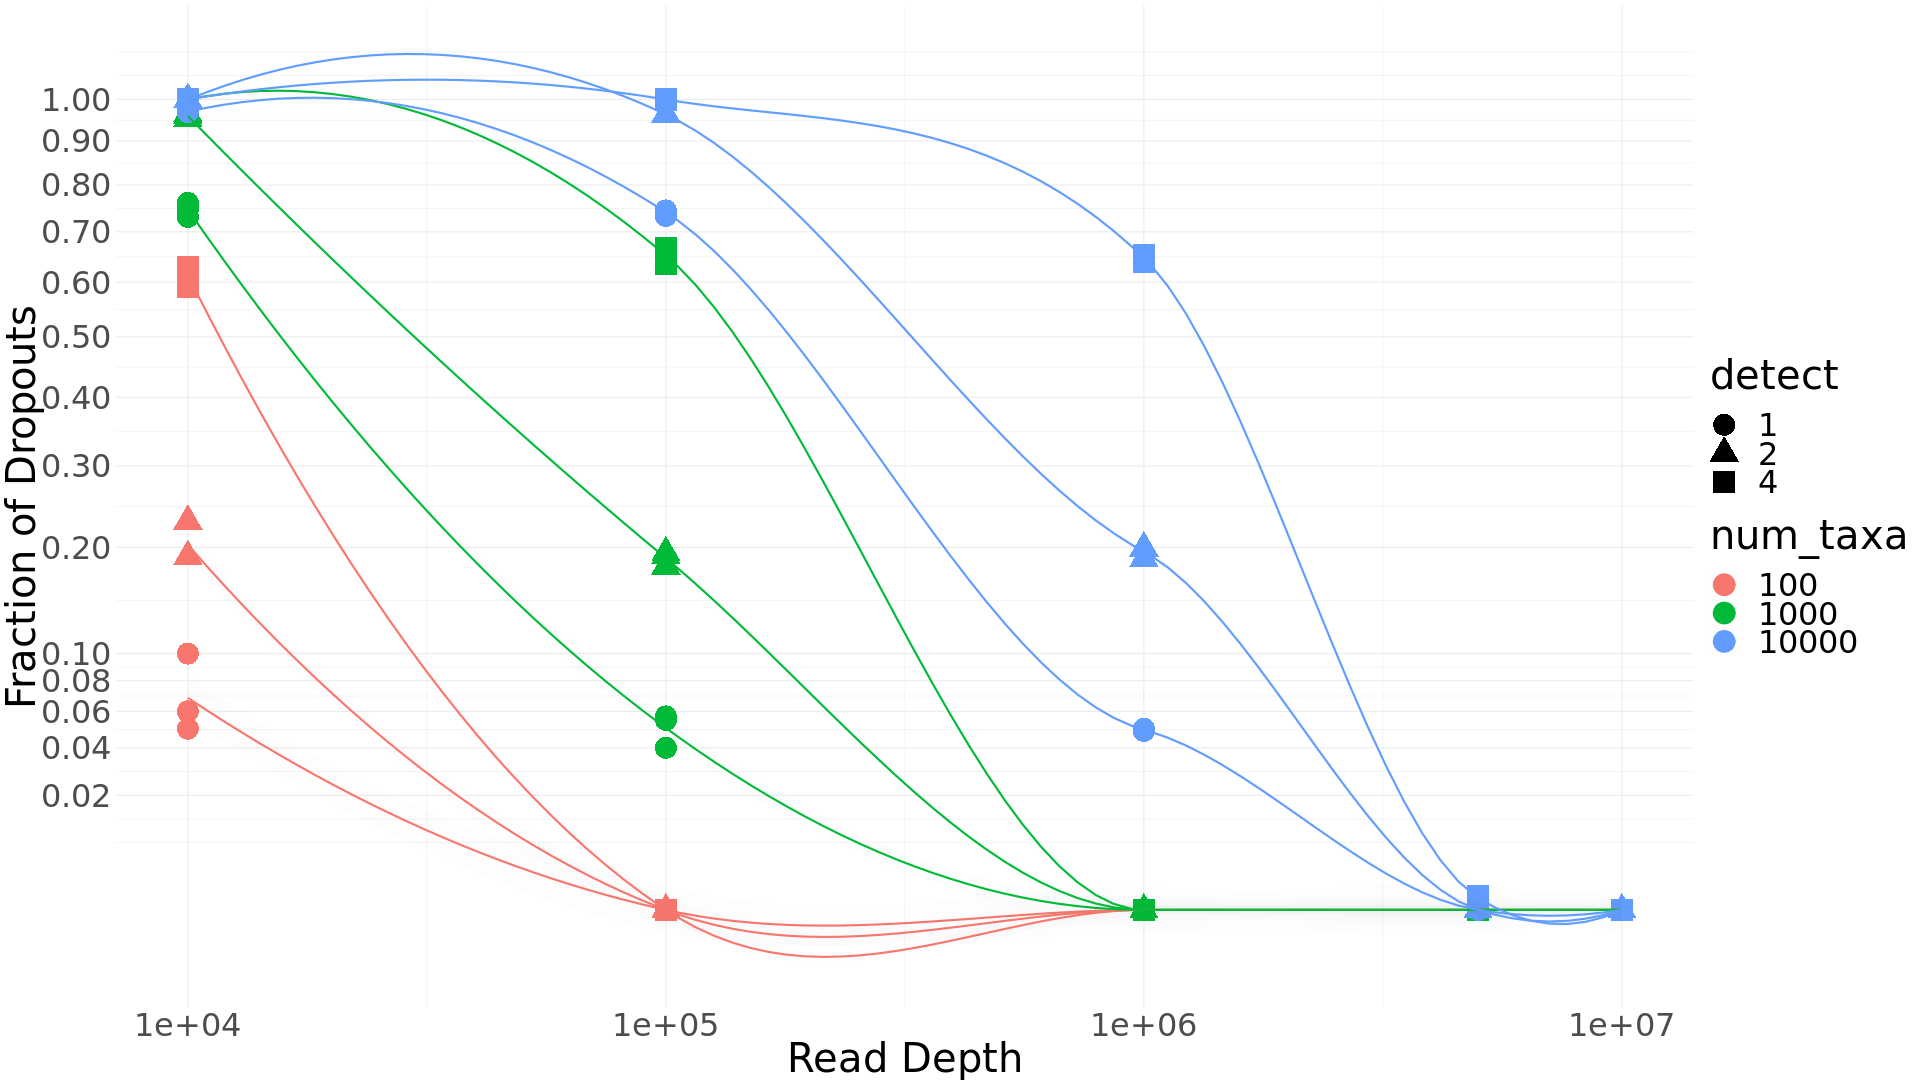

In [221]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl[tbl$num_taxa >= 100 & tbl$detect <=4,]

mytbl$frac_missing = mytbl$num_missing / mytbl$num_taxa
mytbl$detect = as.factor(mytbl$detect)
mytbl$num_taxa = as.factor(mytbl$num_taxa)
ggplot(mytbl, aes(x=read_depth, y=frac_missing, color=num_taxa, shape=detect)) +
    geom_point(size=10) + 
    geom_smooth(method='loess', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    #scale_y_log10(breaks=c(10, 100, 1000, 10000)) +
    scale_y_sqrt(breaks=c(1:4/50, 1:10/10)) +
    scale_x_log10(breaks=c(10000,100000,1000000,10000000)) + 
    xlab('Read Depth') +
    ylab('Fraction of Dropouts')

Takeaway: If we set 2 reads as the minimum detection threshold A 5M read sample will be missing very few of its (1 / 10,000) abundance species. A 1M read sample will be missing ~20%.

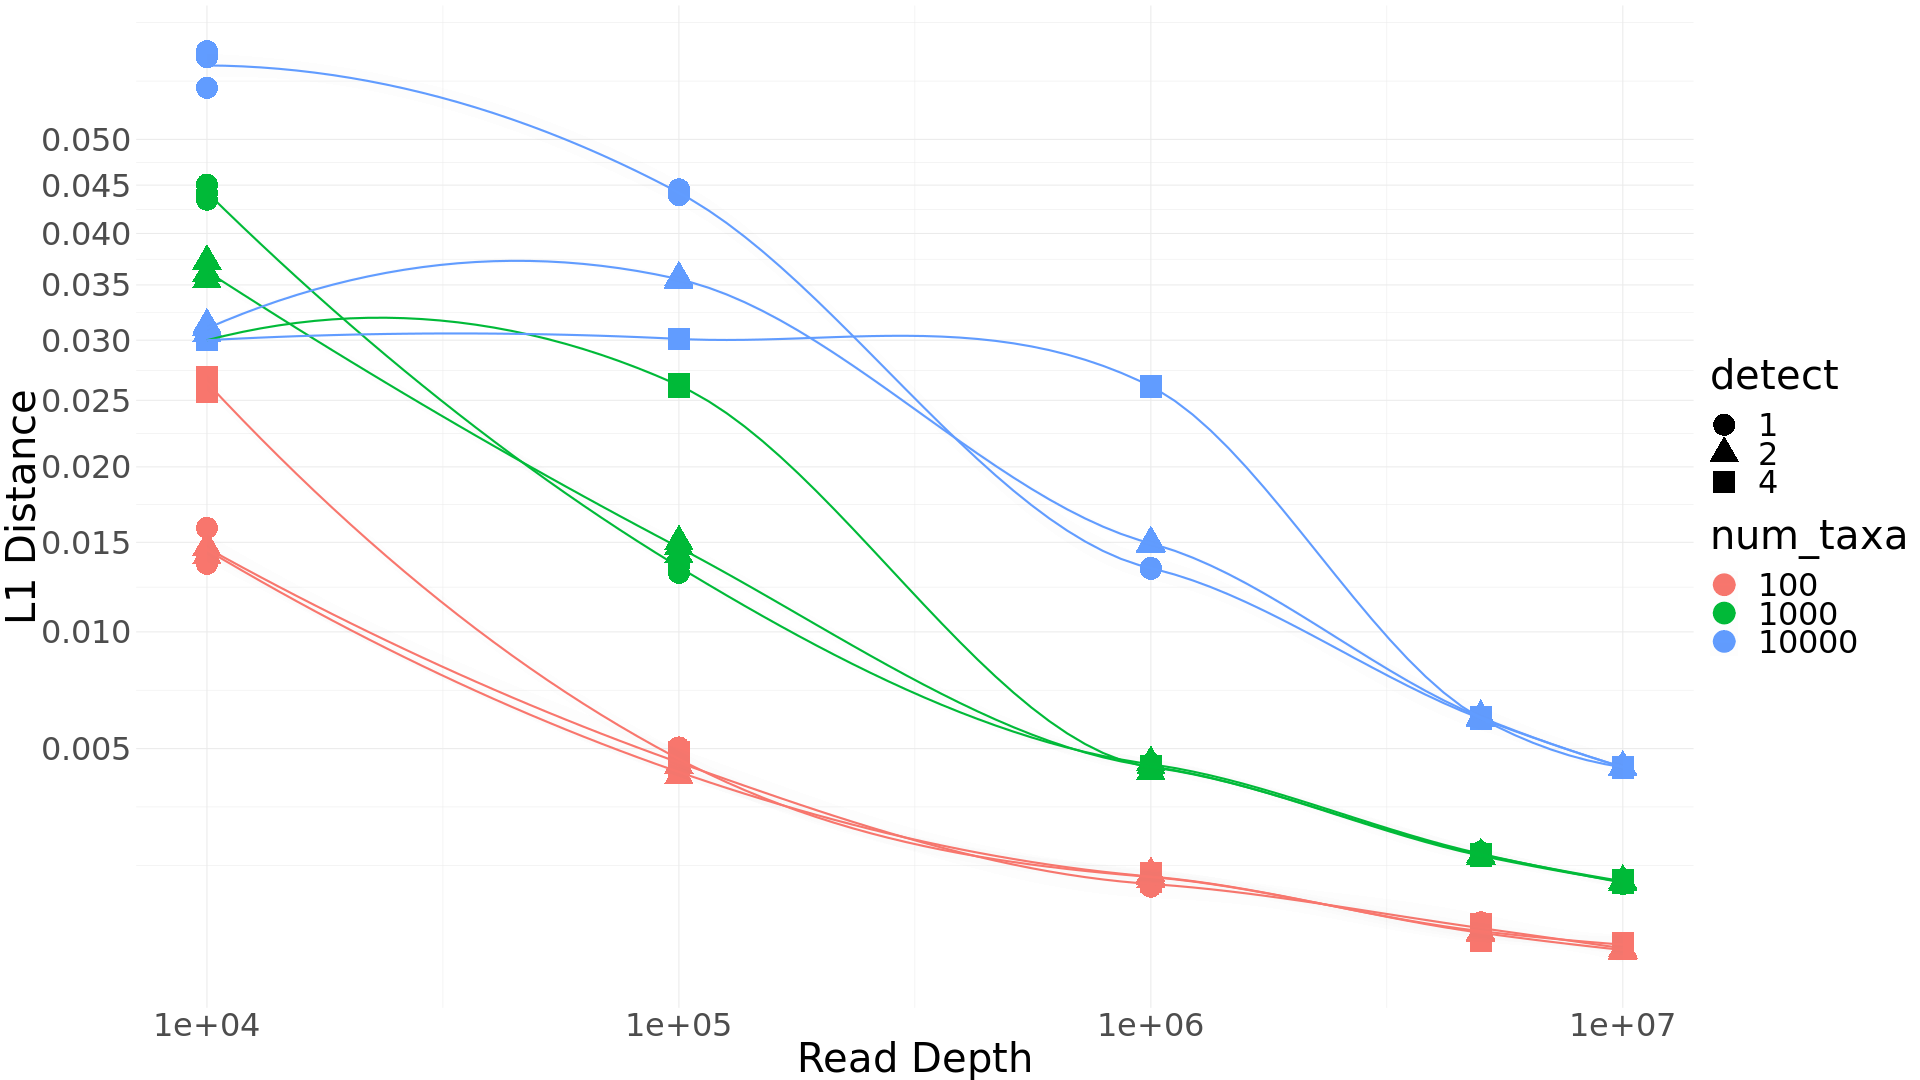

In [223]:
%%R -i tbl  --height 1080 --width 1920
mytbl = tbl[tbl$num_taxa >= 100 & tbl$detect <=4,]

mytbl$frac_missing = mytbl$num_missing / mytbl$num_taxa
mytbl$detect = as.factor(mytbl$detect)
mytbl$num_taxa = as.factor(mytbl$num_taxa)
ggplot(mytbl, aes(x=read_depth, y=l1_dist, color=num_taxa, shape=detect)) +
    geom_point(size=10) + 
    geom_smooth(method='loess', alpha=0.01) +
    theme_minimal() + 
    theme(text = element_text(size=40)) +
    #scale_y_log10(breaks=c(10, 100, 1000, 10000)) +
    scale_y_sqrt(breaks=c(1:10/200)) +
    scale_x_log10(breaks=c(10000,100000,1000000,10000000)) + 
    xlab('Read Depth') +
    ylab('L1 Distance')

This is a little fuzzier because real microbiomes are not even abundance (this is a worst case) but the rough takeaway is that two 5M read microbiomes within an L1 distance of 0.01 cannot be distinguished.

Phrased another way each microbiome is actually a fuzzy sphere of radius ~0.01*

* TODO: should this be l2?

In [198]:
def drawn_to_hit(n, p_i, proportion_uniq=0.03):
    hits, total = 0, 0
    while hits < n:
        total += 1
        hits += 1 if random() < (proportion_uniq * p_i) else 0
    return total

tots = []
for _ in range(10 * 1000):
    tots.append(drawn_to_hit(1, 1 / 10000))

In [199]:
max(tots)

3448672

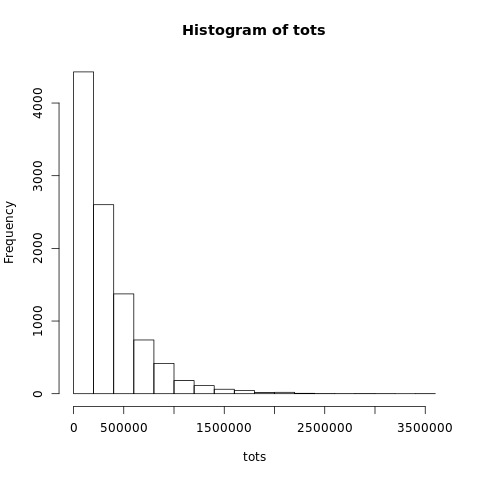

In [200]:
%%R -i tots
tots= as.numeric(tots)
hist(tots)